In [2]:
import matplotlib.pyplot as plt
from base_rl.higher_order import make_train, CONFIG
from gymnax.environments.bsuite import Catch
from base_rl.models import ActorCritic, EquivariantActorCritic, ACSequential, EquivariantCatchActorCritic
from symmetrizer.symmetrizer import ac_symmmetrizer_factory, C2PermGroup
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib
matplotlib.rcParams.update( {"text.usetex": True, "font.family": "serif",})

In [3]:
CONFIG_CATCH = CONFIG.copy()
CONFIG_CATCH["ENV"] = Catch()
CONFIG_CATCH["ENV_PARAMS"] = Catch().default_params
CONFIG_CATCH["TOTAL_TIMESTEPS"] = 20_000
CONFIG_CATCH["ANNEAL_LR"] = False
CONFIG_CATCH["NUM_STEPS"] = 10
CONFIG_CATCH["NUM_ENVS"] = 4

In [4]:
Catch().observation_space(Catch().default_params).shape

(10, 5)

In [5]:
num_seeds = 128
key = jax.random.PRNGKey(42)
sym_key, key = jax.random.split(key)

keys = jax.random.split(key, num_seeds)

def SymmetrizerNet(action_dim: int) -> ACSequential:
    layer_list = [
        CONFIG_CATCH["ENV"].observation_space.shape,
        64,
        64,
    ]
    return ac_symmmetrizer_factory(
        sym_key,
        C2PermGroup(),
        layer_list + [action_dim],
        [True] * (len(layer_list) + 1),
    )

for net_init in [
    ActorCritic,
    EquivariantCatchActorCritic,
]:
    print(net_init.__name__)
    jit_train = jax.vmap(jax.jit(make_train(CONFIG_CATCH, net_init)))
    results = jit_train(keys)
    episodic_returns = results["metrics"][0]["returned_episode_returns"].reshape(
        (num_seeds, -1)
    )
    jnp.save(f"{net_init.__name__}_catch.npy", episodic_returns)
    del jit_train


ActorCritic
EquivariantCatchActorCritic


2023-08-08 07:27:12.853677: W external/xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:523] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  /usr/local/cuda-12.0
  /usr/local/cuda
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


Name: EquivariantCatchActorCritic
Param Size: 6501
Name: ActorCritic
Param Size: 15108


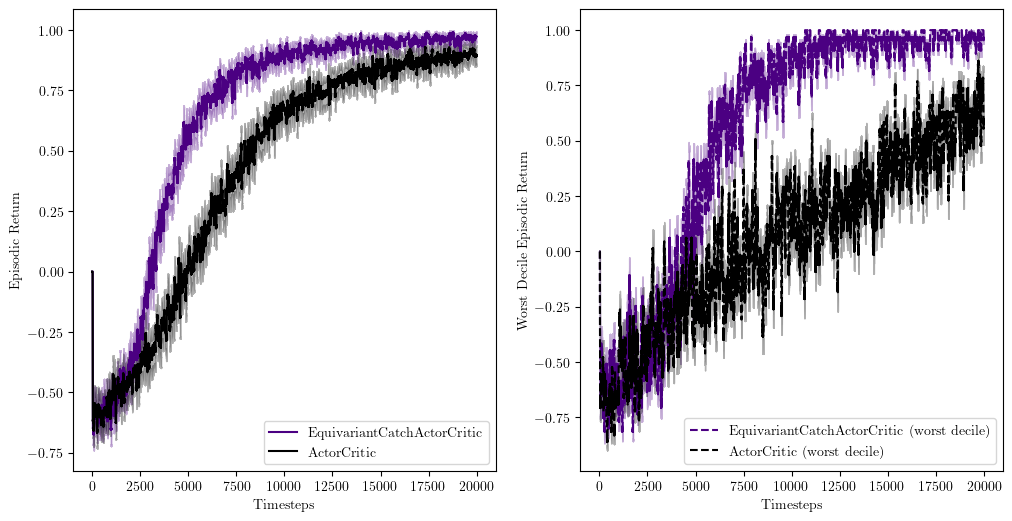

In [6]:
def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), "valid") / w
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
colors = ["indigo", "black", "purple", "red", "green"]
for c, init_fn in zip(
    colors,
    [
        EquivariantCatchActorCritic,
        ActorCritic,
    ],
):
    model = init_fn(3)
    if init_fn in [SymmetrizerNet, EquivariantCatchActorCritic]:
        params = model.init(jax.random.PRNGKey(0), jnp.zeros((1, 50 )))
    else:
        params = model.init(jax.random.PRNGKey(0), jnp.zeros((50)))
    print("Name:", init_fn.__name__)
    # print("Param Count:", jax.tree_util.tree_map(lambda x: x.shape, params))
    print("Param Size:", sum(x.size for x in jax.tree_util.tree_leaves(params)))
    episodic_returns = np.load(f"{init_fn.__name__}_catch.npy")
    returns_std = moving_average(episodic_returns.std(axis=0)) / np.sqrt(num_seeds)
    returns_mean = moving_average(episodic_returns.mean(axis=0))
    returns_upper = returns_mean + returns_std
    returns_lower = returns_mean - returns_std
    x = np.arange(len(returns_mean))

    ax[0].plot(x, returns_mean, label=f"{init_fn.__name__}", color=c)
    ax[0].fill_between(x, returns_lower, returns_upper, alpha=0.3, color=c)
    ax[0].set_xlabel("Timesteps")
    ax[0].set_ylabel("Episodic Return")

    cumulative_returns = np.cumsum(episodic_returns, axis=1)[:, -1]
    worst_decile = np.quantile(cumulative_returns, 0.1)
    worst_mean = episodic_returns[cumulative_returns < worst_decile].mean(axis=0)
    worst_std = episodic_returns[cumulative_returns < worst_decile].std(
        axis=0
    ) / np.sqrt(num_seeds)
    worst_upper = worst_mean + worst_std
    worst_lower = worst_mean - worst_std
    ax[1].plot(
        x,
        moving_average(worst_mean),
        label=f"{init_fn.__name__} (worst decile)",
        linestyle="--",
        color=c,
    )
    ax[1].fill_between(
        x,
        moving_average(worst_lower),
        moving_average(worst_upper),
        alpha=0.3,
        color=c,
    )
    ax[1].set_xlabel("Timesteps")
    ax[1].set_ylabel("Worst Decile Episodic Return")

ax[0].legend()
ax[1].legend()

In [7]:
env = Catch()
model = ActorCritic(3)
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 50)))


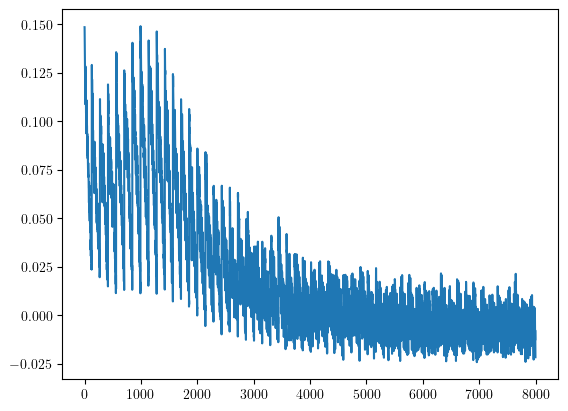

In [8]:
loss = results["metrics"][1][0].mean(axis=0).reshape(-1)
other_losses = results["metrics"][1][1]
plt.plot(loss)

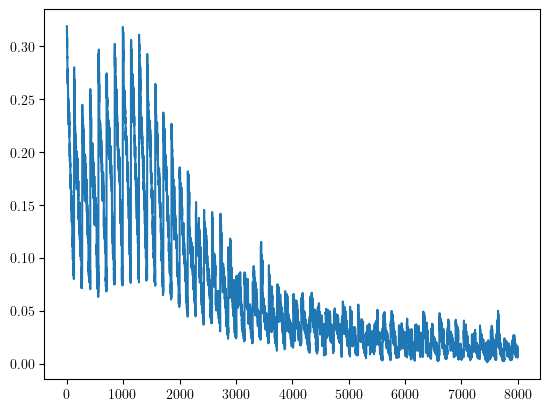

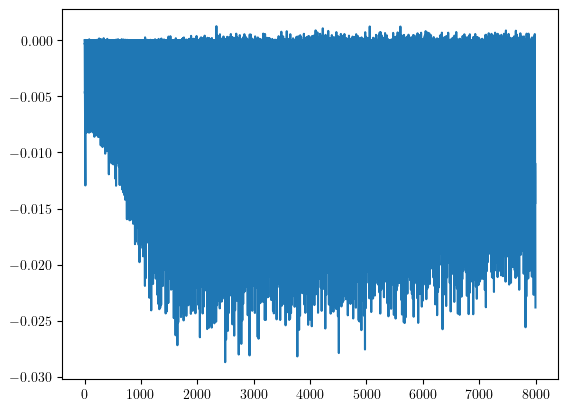

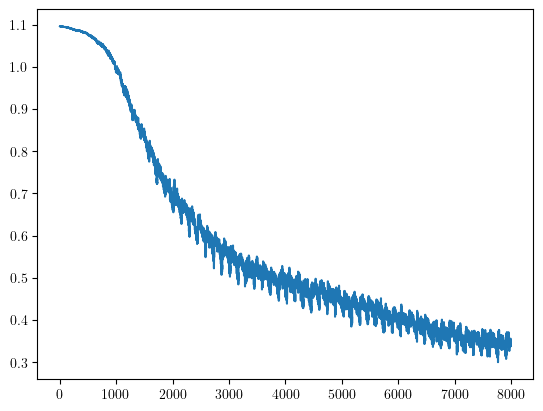

: 

In [9]:
actor_loss, critic_loss, ent_loss = other_losses
actor_loss = actor_loss.mean(axis=0).reshape(-1)
critic_loss = critic_loss.mean(axis=0).reshape(-1)
ent_loss = ent_loss.mean(axis=0).reshape(-1)
plt.plot(actor_loss, label="actor loss")
plt.show()
plt.plot(critic_loss, label="critic loss")
plt.show()
plt.plot(ent_loss, label="entropy loss")